In [1]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, show_summaries
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise

In [2]:
city = 'Pittsburgh'
fig_dir = 'figs/modeling/{}/'.format(city)
data_dir = 'data/{}/'.format(city)

In [3]:
%%time
# Load data

dfb = pd.read_pickle(data_dir + 'business.pkl')
dfr = pd.read_pickle(data_dir + 'review.pkl')
dfu = pd.read_pickle(data_dir + 'user.pkl')
datar = pd.read_pickle(data_dir + 'data_review.pkl')

Wall time: 309 ms


In [4]:
sizes = [datar.shape[0], dfb.shape[0], dfu.shape[0]]
print('Total number of reviews: {}.'.format(datar.shape[0]))
print('Number of restaurants: {}.'.format(dfb.shape[0]))
print('Number of users: {}.'.format(dfu.shape[0]))

del dfb
del dfu
del dfr

IO(data_dir + 'sizes.pkl').to_pickle(sizes)

Total number of reviews: 143682.
Number of restaurants: 4745.
Number of users: 46179.


In [5]:
# Split the dataset into a training set a test set

X_train, X_test, y_train, y_test = train_test_split(datar[['user_id', 'business_id']].values, datar['stars'].values, \
                                                   test_size=0.4, random_state=0)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=0)

data_split = [X_train, y_train, X_test, y_test, X_cv, y_cv]

IO(data_dir + 'data_split.pkl').to_pickle(data_split)

In [6]:
models = [ModeClassifier(), RS_surprise(NormalPredictor()), BaselineMean(), BaselineRegression(), \
          RS_surprise(BaselineOnly()), RS_surprise(KNNBasic()), RS_surprise(KNNWithMeans()), RS_surprise(KNNBaseline()), \
          ALS1(), ALS2(), RS_surprise(SVD()), RS_surprise(SVDpp()), RS_surprise(NMF()), RS_surprise(SlopeOne()), \
          RS_surprise(CoClustering())]
model_names = ['Mode estimator', 'Normal predictor*', 'Baseline (mean)', 'Baseline (regression)', \
              'Baseline (ALS)*', 'KNN (basic)*', 'KNN (with means)*', 'KNN (baseline)*', \
              'SVD-ALS1', 'SVD-ALS2', 'SVD-SGD*', 'SVD++-SGD*', 'NMF-SGD*', 'Slope one*', 'Co-clustering*']
test = [True, True, True, True, \
       True, False, False, False, \
       True, True, True, True, True, True, True]
fignames = [fig_dir + str(i) + 'cm.png' for i in range(len(models))]
datanames = [data_dir + 'results/' + str(i) + '.pkl' for i in range(len(models))]

IO(data_dir + 'results/models.pkl').to_pickle(models)
IO(data_dir + 'results/model_names.pkl').to_pickle(model_names)
IO(data_dir + 'results/fignames.pkl').to_pickle(fignames)
IO(data_dir + 'results/datanames.pkl').to_pickle(datanames)

In [7]:
%%time

is_successful = []

for i, model in enumerate(models):
    try:
        print(model_names[i] + '...')
        if not test[i]:
            print('Estimator not tested')
            is_successful.append(False)
            print()
            continue
        model.fit(X_train, y_train)
        print(model_names[i] + ' fitting successful.')
        model.cv_r2 = model.score(X_cv, y_cv, scoring='r2')
        print(model_names[i] + ' cv r2 calculation successful.')
        try:
            IO(datanames[i]).to_pickle(model)
            print('Saving to pickle successful.')
        except:
            traceback.print_exc()
            print('Saving to pickle failed.')
        del model
        is_successful.append(True)
        print()
    except:
        traceback.print_exc()
        print(model_names[i] + ' failed.')
        is_successful.append(False)
        print()

IO(data_dir + 'results/is_successful.pkl').to_pickle(is_successful)

Mode estimator...
Mode estimator fitting successful.
Mode estimator cv r2 calculation successful.
Saving to pickle successful.

Normal predictor*...
Normal predictor* fitting successful.
Normal predictor* cv r2 calculation successful.
Saving to pickle successful.

Baseline (mean)...
Baseline (mean) fitting successful.
Baseline (mean) cv r2 calculation successful.
Saving to pickle successful.

Baseline (regression)...
Baseline (regression) fitting successful.
Baseline (regression) cv r2 calculation successful.
Saving to pickle successful.

Baseline (ALS)*...
Estimating biases using als...
Baseline (ALS)* fitting successful.
Baseline (ALS)* cv r2 calculation successful.
Saving to pickle successful.

KNN (basic)*...
Estimator not tested

KNN (with means)*...
Estimator not tested

KNN (baseline)*...
Estimator not tested

SVD-ALS1...
SVD-ALS1 fitting successful.
SVD-ALS1 cv r2 calculation successful.
Saving to pickle successful.

SVD-ALS2...
SVD-ALS2 fitting successful.
SVD-ALS2 cv r2 calcu

In [8]:
%%time

is_successful = IO(data_dir + 'results/is_successful.pkl').read_pickle()
datanames = IO(data_dir + 'results/datanames.pkl').read_pickle()
model_names = IO(data_dir + 'results/model_names.pkl').read_pickle()
fignames = IO(data_dir + 'results/fignames.pkl').read_pickle()
X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

results = []
for i in range(len(is_successful)):
    print(model_names[i] + '...')
    if not is_successful[i]:
        results.append(None)
    else:
        model = IO(datanames[i]).read_pickle()
        results.append(get_results(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
                                   X_cv=X_cv, y_cv=y_cv))
        del model
        
print('Done.')
IO(data_dir + 'results/results.pkl').to_pickle(results)

Mode estimator...
Normal predictor*...
Baseline (mean)...
Baseline (regression)...
Baseline (ALS)*...
KNN (basic)*...
KNN (with means)*...
KNN (baseline)*...
SVD-ALS1...
SVD-ALS2...
SVD-SGD*...
SVD++-SGD*...
NMF-SGD*...
Slope one*...
Co-clustering*...
Done.
Wall time: 22.3 s


In [9]:
%%time

model_names = IO(data_dir + 'results/model_names.pkl').read_pickle()
results = IO(data_dir + 'results/results.pkl').read_pickle()
is_successful = IO(data_dir + 'results/is_successful.pkl').read_pickle()
sizes = IO(data_dir + 'sizes.pkl').read_pickle()

display(Markdown('## {} <sup>({} reviews, {} restaurants, {} users)</sup>'.\
                 format(city, sizes[0], sizes[1], sizes[2])))
display(Markdown('**Collaborative filtering**'))
show_summaries(model_names, results, is_successful)
display(Markdown('<sup>(* shows the algorithms we implemented by wrapping around \
methods in scikit-surprise python package)</sup>'))

## Pittsburgh <sup>(143682 reviews, 4745 restaurants, 46179 users)</sup>

**Collaborative filtering**

model,fitting time (s),train RMSE,test RMSE,train $R^2$,test $R^2$
Mode estimator,0.0000,1.8026,1.7988,-0.8466,-0.8393
Normal predictor*,0.4550,1.7307,1.7303,-0.7022,-0.7017
Baseline (mean),0.1020,0.9052,1.3198,0.5343,0.0099
Baseline (regression),0.2000,0.9941,1.1878,0.4384,0.1980
Baseline (ALS)*,0.5780,1.1119,1.2020,0.2974,0.1788
SVD-ALS1,79.5536,0.5627,1.1960,0.8200,0.1870
SVD-ALS2,82.5507,0.5651,1.2010,0.8185,0.1801
SVD-SGD*,7.5524,0.8267,1.2046,0.6116,0.1752
SVD++-SGD*,43.6945,0.8738,1.2025,0.5661,0.1780
NMF-SGD*,9.3785,0.3666,1.3761,0.9236,-0.0765


<sup>(* shows the algorithms we implemented by wrapping around methods in scikit-surprise python package)</sup>

Wall time: 28 ms


### Mode estimator

Fitting time: 0.0000 s.  
            RMSE on training set: 1.8026.  
            RMSE on test set: 1.7988.  
            $R^2$ on training set: -0.8466.  
            $R^2$ on cross-validation set: -0.8513.  
            $R^2$ on test set: -0.8393.  
            Classification accuracy on training set: 0.3965.  
            Classification accuracy on test set: 0.3993.
            

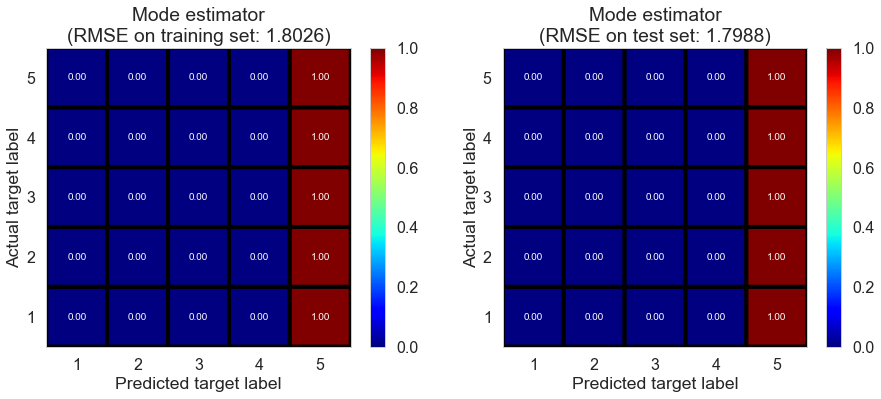

### Normal predictor*

Fitting time: 0.4550 s.  
            RMSE on training set: 1.7307.  
            RMSE on test set: 1.7303.  
            $R^2$ on training set: -0.7022.  
            $R^2$ on cross-validation set: -0.7165.  
            $R^2$ on test set: -0.7017.  
            Classification accuracy on training set: 0.2452.  
            Classification accuracy on test set: 0.2458.
            

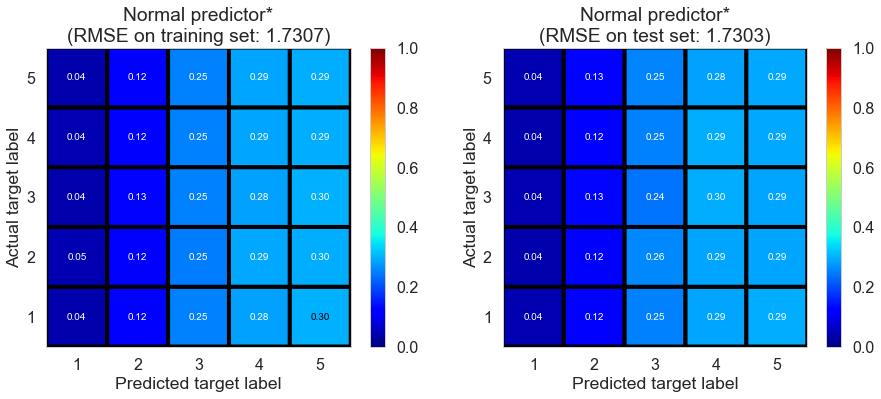

### Baseline (mean)

Fitting time: 0.1020 s.  
            RMSE on training set: 0.9052.  
            RMSE on test set: 1.3198.  
            $R^2$ on training set: 0.5343.  
            $R^2$ on cross-validation set: -0.0128.  
            $R^2$ on test set: 0.0099.  
            Classification accuracy on training set: 0.5689.  
            Classification accuracy on test set: 0.3629.
            

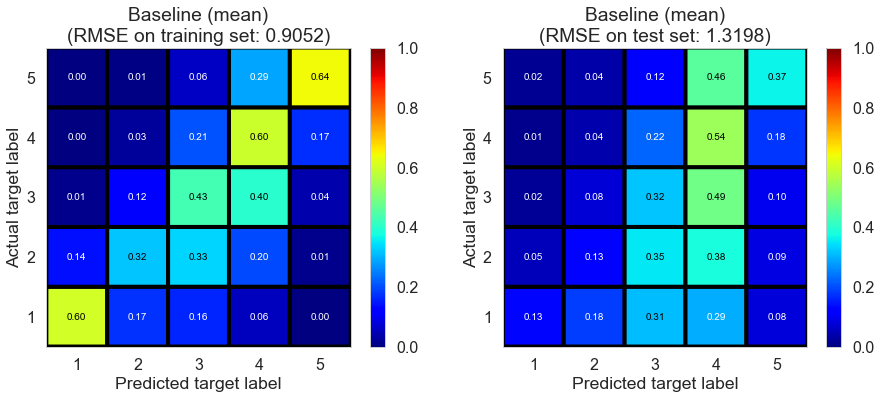

### Baseline (regression)

Fitting time: 0.2000 s.  
            RMSE on training set: 0.9941.  
            RMSE on test set: 1.1878.  
            $R^2$ on training set: 0.4384.  
            $R^2$ on cross-validation set: 0.1882.  
            $R^2$ on test set: 0.1980.  
            Classification accuracy on training set: 0.3640.  
            Classification accuracy on test set: 0.3094.
            

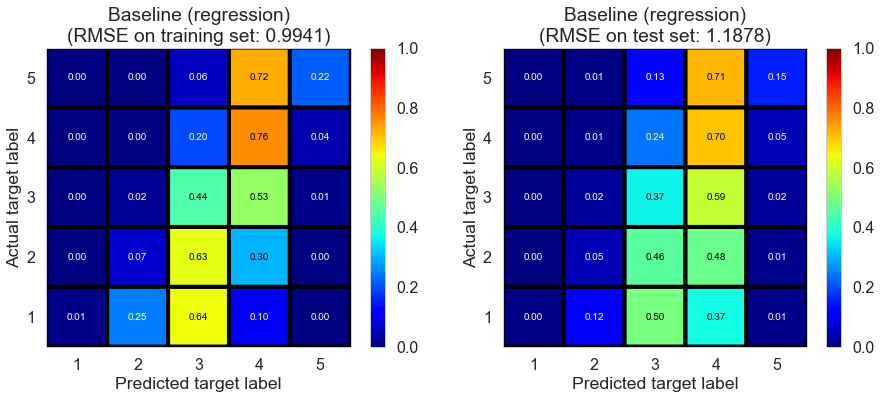

### Baseline (ALS)*

Fitting time: 0.5780 s.  
            RMSE on training set: 1.1119.  
            RMSE on test set: 1.2020.  
            $R^2$ on training set: 0.2974.  
            $R^2$ on cross-validation set: 0.1712.  
            $R^2$ on test set: 0.1788.  
            Classification accuracy on training set: 0.3149.  
            Classification accuracy on test set: 0.2919.
            

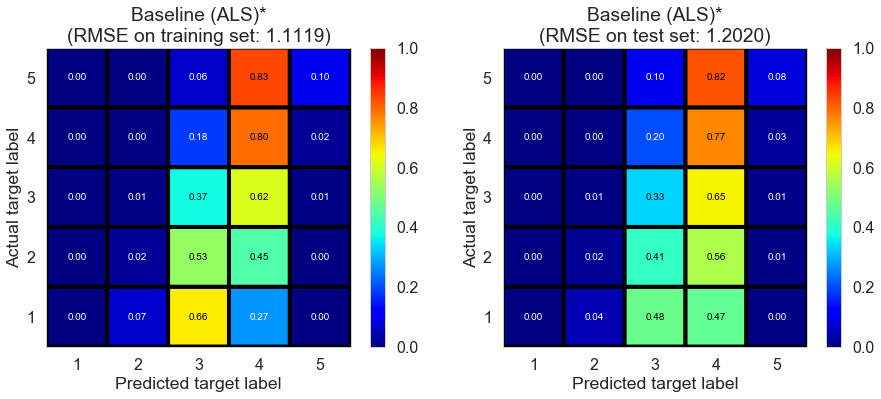

### SVD-ALS1

Fitting time: 79.5536 s.  
            RMSE on training set: 0.5627.  
            RMSE on test set: 1.1960.  
            $R^2$ on training set: 0.8200.  
            $R^2$ on cross-validation set: 0.1788.  
            $R^2$ on test set: 0.1870.  
            Classification accuracy on training set: 0.7112.  
            Classification accuracy on test set: 0.3068.
            

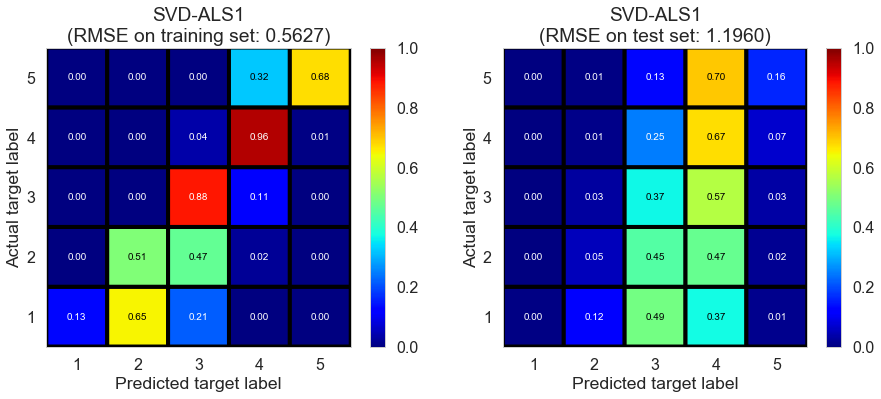

### SVD-ALS2

Fitting time: 82.5507 s.  
            RMSE on training set: 0.5651.  
            RMSE on test set: 1.2010.  
            $R^2$ on training set: 0.8185.  
            $R^2$ on cross-validation set: 0.1723.  
            $R^2$ on test set: 0.1801.  
            Classification accuracy on training set: 0.7050.  
            Classification accuracy on test set: 0.2974.
            

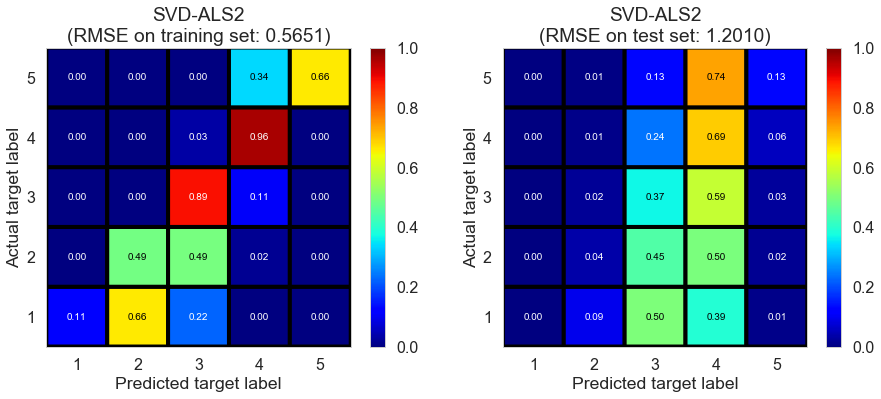

### SVD-SGD*

Fitting time: 7.5524 s.  
            RMSE on training set: 0.8267.  
            RMSE on test set: 1.2046.  
            $R^2$ on training set: 0.6116.  
            $R^2$ on cross-validation set: 0.1689.  
            $R^2$ on test set: 0.1752.  
            Classification accuracy on training set: 0.4453.  
            Classification accuracy on test set: 0.3029.
            

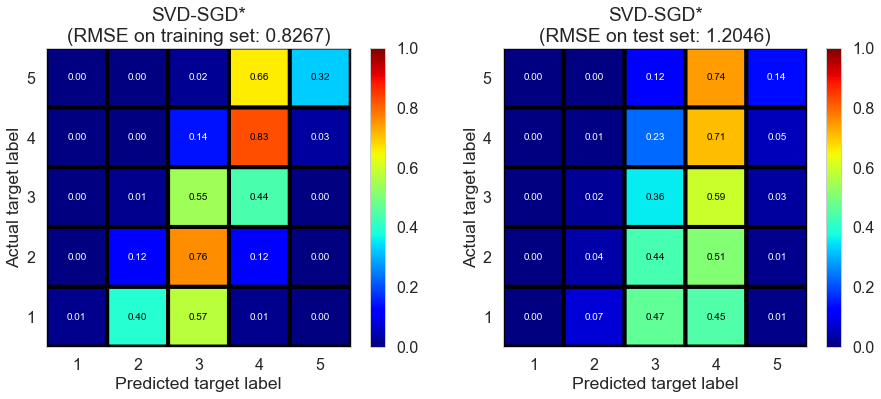

### SVD++-SGD*

Fitting time: 43.6945 s.  
            RMSE on training set: 0.8738.  
            RMSE on test set: 1.2025.  
            $R^2$ on training set: 0.5661.  
            $R^2$ on cross-validation set: 0.1693.  
            $R^2$ on test set: 0.1780.  
            Classification accuracy on training set: 0.4389.  
            Classification accuracy on test set: 0.3059.
            

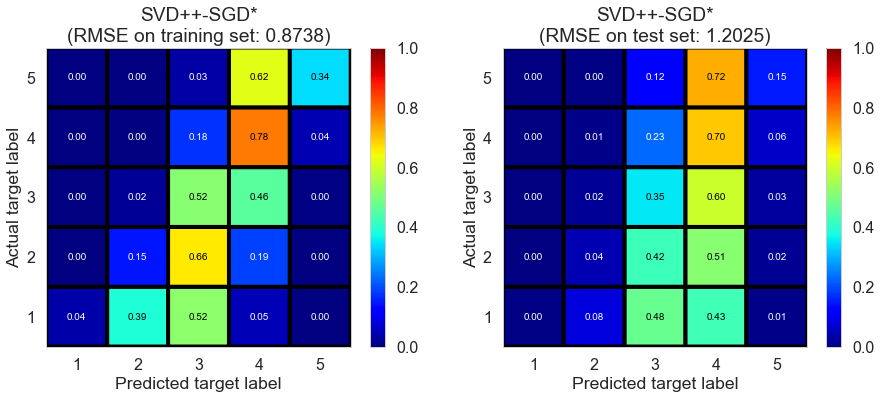

### NMF-SGD*

Fitting time: 9.3785 s.  
            RMSE on training set: 0.3666.  
            RMSE on test set: 1.3761.  
            $R^2$ on training set: 0.9236.  
            $R^2$ on cross-validation set: -0.0797.  
            $R^2$ on test set: -0.0765.  
            Classification accuracy on training set: 0.8656.  
            Classification accuracy on test set: 0.2893.
            

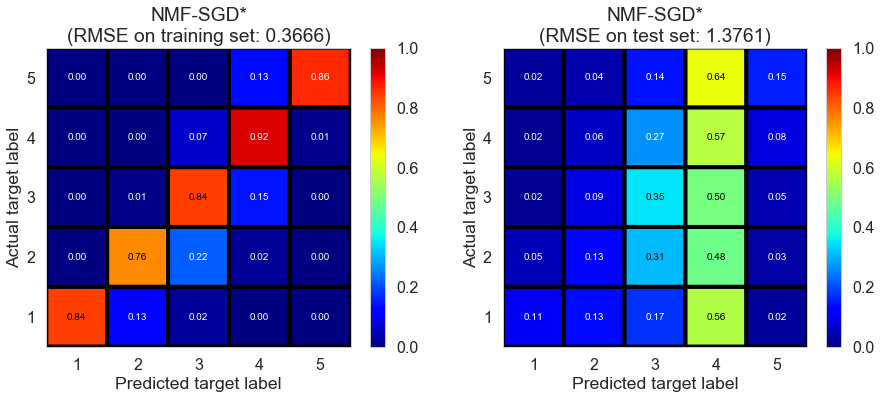

### Slope one*

Fitting time: 1.8091 s.  
            RMSE on training set: 0.3685.  
            RMSE on test set: 1.3870.  
            $R^2$ on training set: 0.9228.  
            $R^2$ on cross-validation set: -0.0970.  
            $R^2$ on test set: -0.0935.  
            Classification accuracy on training set: 0.8579.  
            Classification accuracy on test set: 0.3220.
            

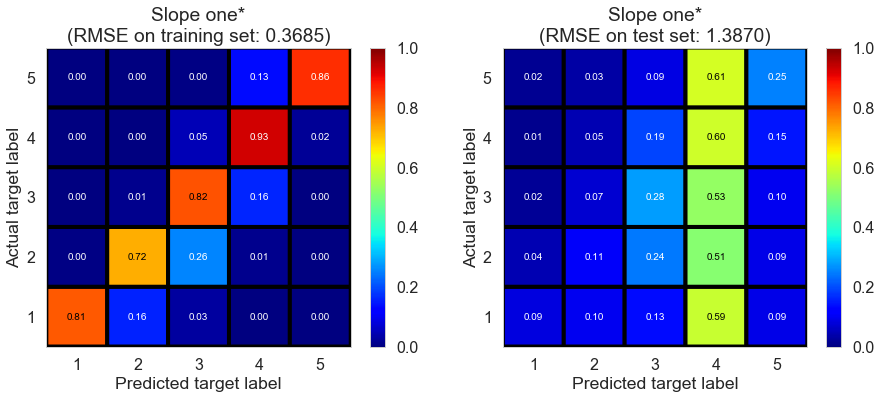

### Co-clustering*

Fitting time: 7.8524 s.  
            RMSE on training set: 0.7938.  
            RMSE on test set: 1.3291.  
            $R^2$ on training set: 0.6419.  
            $R^2$ on cross-validation set: -0.0259.  
            $R^2$ on test set: -0.0041.  
            Classification accuracy on training set: 0.5884.  
            Classification accuracy on test set: 0.3442.
            

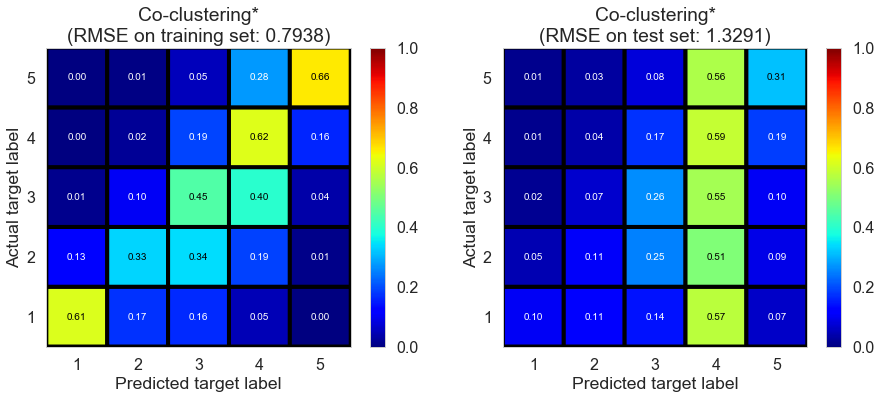


Wall time: 7.7 s


In [10]:
%%time

is_successful = IO(data_dir + 'results/is_successful.pkl').read_pickle()
datanames = IO(data_dir + 'results/datanames.pkl').read_pickle()
model_names = IO(data_dir + 'results/model_names.pkl').read_pickle()
fignames = IO(data_dir + 'results/fignames.pkl').read_pickle()
results = IO(data_dir + 'results/results.pkl').read_pickle()
X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

for i in range(len(is_successful)):
    if is_successful[i]:
        model = IO(datanames[i]).read_pickle()
        show_results(model, model_names[i], X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, \
                     results=results[i], show_cv=True)
        del model